
# Churn Prediction Model with Pyspark

The aim is to estimate whether a bank's customers leave the bank or not. The event that defines the customer abandonment is the closing of the customer's bank account.

Details about the dataset:
It consists of 10000 observations and 12 variables. Independent variables contain information about customers. Dependent variable refers to customer abandonment status.

Variables:
RowNumber — corresponds to the record (row) number and has no effect on the output. This column will be removed.

CustomerId — contains random values and has no effect on customer leaving the bank. This column will be removed.

Surname — the surname of a customer has no impact on their decision to leave the bank. This column will be removed.

CreditScore — can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.

Geography — a customer’s location can affect their decision to leave the bank. We’ll keep this column.

Gender — it’s interesting to explore whether gender plays a role in a customer leaving the bank. We’ll include this column, too.

Age — this is certainly relevant, since older customers are less likely to leave their bank than younger ones.

Tenure — refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

Balance — also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.

NumOfProducts — refers to the number of products that a customer has purchased through the bank.

HasCrCard — denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank. (0=No,1=Yes)

IsActiveMember — active customers are less likely to leave the bank, so we’ll keep this. (0=No,1=Yes)

EstimatedSalary — as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

Exited — whether or not the customer left the bank. This is what we have to predict. (0=No,1=Yes)


## Data Understanding

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

import findspark
findspark.init("C:\spark")

spark = SparkSession.builder \
    .master("local") \
    .appName("Churn?") \
    .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

sc = spark.sparkContext
sc

<SparkContext master=local appName=Churn?>

In [2]:
spark_df = spark.read.csv("churn.csv", header=True, inferSchema=True) # Read the data set.
spark_df.toPandas().head() # Use toPandas to get a better view

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Get rid of the useless features for machine learning model.

drop_list = ["RowNumber", "CustomerId", "Surname"]

for col in drop_list:
    spark_df = spark_df.drop(col)

spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
spark_df.describe().toPandas().head()

,summary,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,mean,650.5288,None,None,38.9218,5.0128,76485.88928799961,1.5302,0.7055,0.5151,100090.2398809998,0.2037
2,stddev,96.65329873613035,None,None,10.487806451704587,2.8921743770496837,62397.40520238599,0.5816543579989917,0.45584046447513327,0.49979692845891815,57510.49281769821,0.40276858399486065
3,min,350,France,Female,18,0,0.0,1,0,0,11.58,0
4,max,850,Spain,Male,92,10,250898.09,4,1,1,199992.48,1


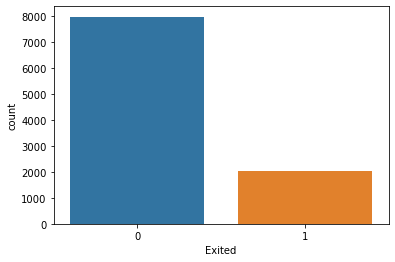

In [5]:
sdf = spark_df.select('Exited').toPandas()
sns.countplot(sdf['Exited'], label="Count"); # By looking at the graph it is safe to say this is an unbalanced data set

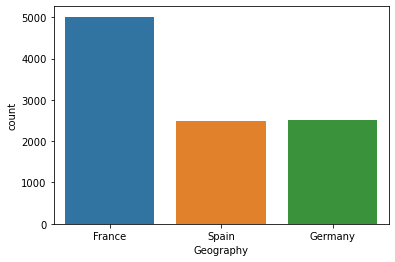

In [6]:
sdf = spark_df.select('Geography').toPandas()
sns.countplot(sdf['Geography'], label="Count");

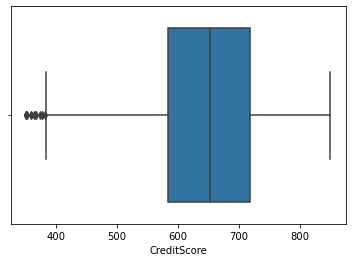

In [7]:
sdf = spark_df.select('CreditScore').toPandas()
sns.boxplot(sdf["CreditScore"]);

In [8]:
# df[df["CreditScore"]<405].apply({"Exited": "value_counts"}) --> pandas version
spark_df.filter(spark_df.CreditScore < 405).agg({"Exited": "count"}).show() 

+-------------+
|count(Exited)|
+-------------+
|           21|
+-------------+



## FEATURE ENGINEERING

In [9]:
# df["FE_Credit"] = df.apply((lambda row: 1 if row["CreditScore"] > 405 else 0), axis=1) --> pandas version

import pyspark.sql.functions as F
from pyspark.sql.types import *

def credit_score(value):
    if value < 405: 
        return 0
    else:
        return 1

#convert to a UDF Function by passing in the function and return type of function
udf_credit_score = F.udf(credit_score, IntegerType())
spark_df = spark_df.withColumn("FE_Credit", udf_credit_score("CreditScore"))
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,FE_Credit
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1


In [10]:
# df["FE_Retired"] = df.apply((lambda row: "Retired" if row["Age"] > 65 else "Non-Retired"), axis=1) --> pandas version

def retired(value):
    if value > 65: 
        return "Retired"
    else:
        return "Non-Retired"

udf_retired = F.udf(retired, StringType())
spark_df = spark_df.withColumn("FE_Retired", udf_retired("Age"))
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,FE_Credit,FE_Retired
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,Non-Retired
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,Non-Retired
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,Non-Retired
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,Non-Retired
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1,Non-Retired


In [11]:
# df.groupby("NumOfProducts").agg({"Exited": "mean"}) --> pandas version
spark_df.groupby("NumOfProducts").agg({"Exited": "mean"}) 

NumOfProducts,avg(Exited)
1,0.27714398111723054
3,0.8270676691729323
4,1.0
2,0.07581699346405228


In [12]:
# df["FE_NumOfProducts"] = df.apply((lambda row: 1 if row["NumOfProducts"] == 4 else 0), axis=1) --> pandas version


# It is also possible to create new features with SQL commands in pyspark
# we need to register a temporary SQL table and then use simple select queries with an additional column
spark_df.registerTempTable('temp_df') 
spark_df = spark.sql("""SELECT *, 
CASE
    WHEN NumOfProducts == 4 THEN 1
    ELSE 0
END AS FE_NumOfProducts
FROM temp_df""")
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,FE_Credit,FE_Retired,FE_NumOfProducts
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,Non-Retired,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,Non-Retired,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,Non-Retired,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,Non-Retired,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1,Non-Retired,0


In [13]:
# df["ES/Age"]=df["EstimatedSalary"]/(df["Age"]-17)

spark_df = spark_df.withColumn("ES/Age", spark_df.EstimatedSalary / spark_df.Age - 17)
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,FE_Credit,FE_Retired,FE_NumOfProducts,ES/Age
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,Non-Retired,0,2396.068571
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,Non-Retired,0,2727.940976
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,Non-Retired,0,2695.656429
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,Non-Retired,0,2388.811026
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1,Non-Retired,0,1822.165116


## CATEGORICAL VARIABLE ANALYSIS

In [41]:
cat_cols = ["Geography", "Gender", "HasCrCard", "IsActiveMember", "FE_Retired", "FE_Credit", "FE_NumOfProducts", "NumOfProducts"]


def cat_summary(data, categorical_cols, target, number_of_classes=10):
    temp_data = data.toPandas()
    var_count = 0
    vars_more_classes = []
    for var in categorical_cols:
        if len(temp_data[var].value_counts()) <= number_of_classes:
            print(pd.DataFrame({var: temp_data[var].value_counts(),
                                "Ratio": temp_data[var].value_counts() / len(temp_data),
                                "Target Mean": temp_data.groupby(var)[target].mean()}), end="\n\n\n")
            var_count += 1
        else:
            vars_more_classes.append(var)
    print('%d categorical variables have been described.' % var_count, end="\n\n")
    print(len(vars_more_classes), "categorical variables have more than", number_of_classes, "classes.", end="\n\n")
    print('Variable names have more than %d classes:' % number_of_classes, end="\n\n")
    print(vars_more_classes)

cat_summary(spark_df, cat_cols, "Exited")

           Geography   Ratio  Target Mean
Geography                                
France          5014  0.5014     0.161548
Germany         2509  0.2509     0.324432
Spain           2477  0.2477     0.166734


        Gender   Ratio  Target Mean
Female    4543  0.4543     0.250715
Male      5457  0.5457     0.164559


   HasCrCard   Ratio  Target Mean
0       2945  0.2945     0.208149
1       7055  0.7055     0.201843


   IsActiveMember   Ratio  Target Mean
0            4849  0.4849     0.268509
1            5151  0.5151     0.142691


             FE_Retired   Ratio  Target Mean
FE_Retired                                  
Non-Retired        9736  0.9736     0.205629
Retired             264  0.0264     0.132576


   FE_Credit   Ratio  Target Mean
0         21  0.0021     1.000000
1       9979  0.9979     0.202024


   FE_NumOfProducts  Ratio  Target Mean
0              9940  0.994     0.198893
1                60  0.006     1.000000


   NumOfProducts   Ratio  Target Mean
1        

## NUMERICAL VARIABLE ANALYSIS

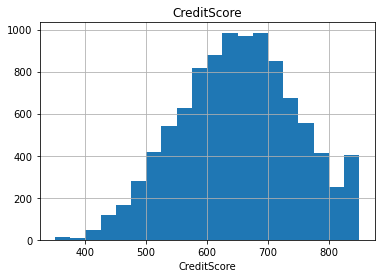

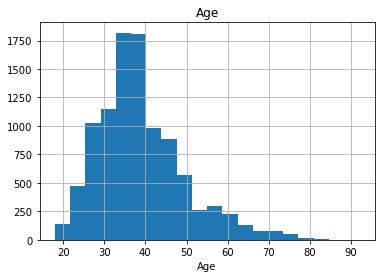

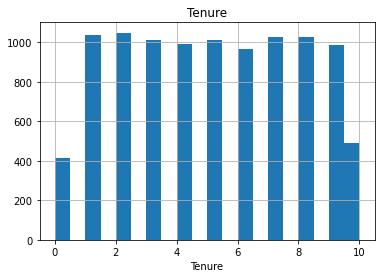

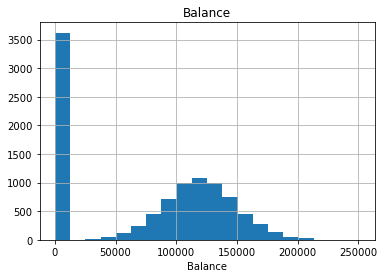

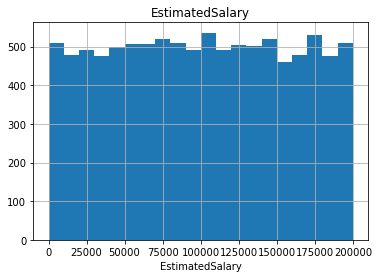

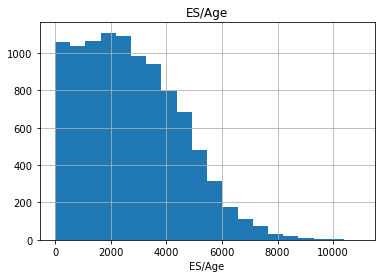

6 variables have been plotted


In [42]:
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "ES/Age"]

def hist_for_nums(data, numeric_cols):
    temp_data = data.toPandas()
    col_counter = 0
    for col in numeric_cols:
        temp_data[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")
  
hist_for_nums(spark_df, num_cols)

In [43]:
# corelations between the target and independent variables
def find_correlation(dataframe, target, numeric_cols, corr_limit=0.60):
    temp_data = dataframe.toPandas()
    high_correlations = []
    low_correlations = []
    for col in numeric_cols:
        if col == target:
            pass
        else:
            correlation = temp_data[[col, "Exited"]].corr().loc[col, "Exited"]
            print(col, correlation)
            if abs(correlation) > corr_limit:
                high_correlations.append(col + ": " + str(correlation))
            else:
                low_correlations.append(col + ": " + str(correlation))
    return low_correlations, high_correlations


low_corrs, high_corrs = find_correlation(spark_df, "Exited", num_cols)

CreditScore -0.027093539754658398
Age 0.2853230378350968
Tenure -0.014000612253444792
Balance 0.11853276877163839
EstimatedSalary 0.012096861026845011
ES/Age -0.1030795393978088


In [44]:
high_corrs

[]

In [45]:
low_corrs

['CreditScore: -0.027093539754658398',
 'Age: 0.2853230378350968',
 'Tenure: -0.014000612253444792',
 'Balance: 0.11853276877163839',
 'EstimatedSalary: 0.012096861026845011',
 'ES/Age: -0.1030795393978088']

In [47]:
# Check if there are any outliers; if so, replace them either with upper or lower limits

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def has_outliers(dataframe, num_col_names, plot=False):
    temp_df = dataframe.toPandas()
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(temp_df, col)
        if temp_df[(temp_df[col] > up_limit) | (temp_df[col] < low_limit)].any(axis=None):
            number_of_outliers = temp_df[(temp_df[col] > up_limit) | (temp_df[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=temp_df[col])
                plt.show()
    return variable_names


has_outliers(spark_df, num_cols)

[]

In [48]:
# Check if there are any Null values in the data set
from pyspark.sql.functions import isnan, when, count, col
spark_df.select([count(when(isnan(c), c)).alias(c) for c in spark_df.columns])
# spark_df = spark_df.dropna() # drop the rows that have null values just like in pandas

CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,FE_Credit,FE_Retired,FE_NumOfProducts,ES/Age
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## SELECTING THE DEPENDENT VARIABLE (LABEL)

In [49]:
from pyspark.ml.feature import StringIndexer

# for spark, the definition of dependent value is label.

stringIndexer = StringIndexer(inputCol ="Exited", outputCol = "label")
mod = stringIndexer.fit(spark_df) 
indexed = mod.transform(spark_df)
spark_df = indexed.withColumn("label", indexed["label"].cast("integer"))
spark_df = spark_df.drop("Exited")
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,FE_Credit,FE_Retired,FE_NumOfProducts,ES/Age,label
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Non-Retired,0,2396.068571,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,Non-Retired,0,2727.940976,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Non-Retired,0,2695.656429,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1,Non-Retired,0,2388.811026,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1,Non-Retired,0,1822.165116,0


## SELECTING THE INDEPENDENT VARIABLES (FEATURES)

In [50]:
col_type = spark_df.dtypes # from spark dataframe take variabe names and data types as list
col_type

[('CreditScore', 'int'),
 ('Geography', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('FE_Credit', 'int'),
 ('FE_Retired', 'string'),
 ('FE_NumOfProducts', 'int'),
 ('ES/Age', 'double'),
 ('label', 'int')]

In [51]:
# select the categorical variables
cat_cols = [col[0] for col in col_type if col[1] == "string"]
cat_cols

['Geography', 'Gender', 'FE_Retired']

In [52]:
def indexer_for_catcols(categorical_cols, spark_df):
    from pyspark.ml.feature import StringIndexer
    """This function takes categorical column names in list and spark dataframe as arguments.
    It returns a list of labeled categorical names and new spark dataframe"""
    cat_col_num_name = []
    for i in categorical_cols:
        cat_col_num_name.append(i + "_num")
        indexer = StringIndexer(inputCol = i, outputCol = i + "_num") 
        indexer_model = indexer.fit(spark_df)
        indexer_df = indexer_model.transform(spark_df)
        spark_df = indexer_df
    return cat_col_num_name, spark_df

cat_col_num_name, spark_df = indexer_for_catcols(cat_cols, spark_df)
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,FE_Credit,FE_Retired,FE_NumOfProducts,ES/Age,label,Geography_num,Gender_num,FE_Retired_num
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Non-Retired,0,2396.068571,1,0.0,1.0,0.0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,Non-Retired,0,2727.940976,0,2.0,1.0,0.0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Non-Retired,0,2695.656429,1,0.0,1.0,0.0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1,Non-Retired,0,2388.811026,0,0.0,1.0,0.0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1,Non-Retired,0,1822.165116,0,2.0,1.0,0.0


## One Hot Encoder

In [53]:
def one_hot_encoder(cat_col_num_name, spark_df):
    """This function takes categorical column names that were found with indexer_for_catcols function in list and spark dataframe as 
    arguments. It returns encoded spark dataframe"""
    from pyspark.ml.feature import OneHotEncoder 
    for i in cat_col_num_name:
        encoder = OneHotEncoder(inputCol = i, outputCol = i + "_ohe")
        model = encoder.fit(spark_df)
        encoded = model.transform(spark_df)
        encoded = encoded.drop(i)
        spark_df = encoded
    return spark_df

spark_df = one_hot_encoder(cat_col_num_name, spark_df)
spark_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,FE_Credit,FE_Retired,FE_NumOfProducts,ES/Age,label,Geography_num_ohe,Gender_num_ohe,FE_Retired_num_ohe
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Non-Retired,0,2396.068571,1,"(1.0, 0.0)",(0.0),(1.0)
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,Non-Retired,0,2727.940976,0,"(0.0, 0.0)",(0.0),(1.0)
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Non-Retired,0,2695.656429,1,"(1.0, 0.0)",(0.0),(1.0)
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1,Non-Retired,0,2388.811026,0,"(1.0, 0.0)",(0.0),(1.0)
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1,Non-Retired,0,1822.165116,0,"(0.0, 0.0)",(0.0),(1.0)


In [54]:
num_cols = [col[0] for col in col_type if col[1] != "string" and col[0] != "label"]
num_cols # num cols which will be used in the model

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'FE_Credit',
 'FE_NumOfProducts',
 'ES/Age']

In [55]:
# Independent variables are changed as vectors and sent to spark
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols=num_cols, outputCol="features")
va_df = va.transform(spark_df)
va_df.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,FE_Credit,FE_Retired,FE_NumOfProducts,ES/Age,label,Geography_num_ohe,Gender_num_ohe,FE_Retired_num_ohe,features
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Non-Retired,0,2396.068571,1,"(1.0, 0.0)",(0.0),(1.0),"[619.0, 42.0, 2.0, 0.0, 1.0, 1.0, 1.0, 101348...."
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,Non-Retired,0,2727.940976,0,"(0.0, 0.0)",(0.0),(1.0),"[608.0, 41.0, 1.0, 83807.86, 1.0, 0.0, 1.0, 11..."
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Non-Retired,0,2695.656429,1,"(1.0, 0.0)",(0.0),(1.0),"[502.0, 42.0, 8.0, 159660.8, 3.0, 1.0, 0.0, 11..."
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1,Non-Retired,0,2388.811026,0,"(1.0, 0.0)",(0.0),(1.0),"[699.0, 39.0, 1.0, 0.0, 2.0, 0.0, 0.0, 93826.6..."
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1,Non-Retired,0,1822.165116,0,"(0.0, 0.0)",(0.0),(1.0),"[850.0, 43.0, 2.0, 125510.82, 1.0, 1.0, 1.0, 7..."


## Standardizing

In [56]:
from pyspark.ml.feature import RobustScaler


scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures",
                      withScaling=True, withCentering=False,
                      lower=0.25, upper=0.75)

# Compute summary statistics by fitting the RobustScaler
scalerModel = scaler.fit(va_df)

# Transform each feature to have unit quantile range.
scaledData = scalerModel.transform(va_df)
scaledData.toPandas().head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,FE_Credit,FE_Retired,FE_NumOfProducts,ES/Age,label,Geography_num_ohe,Gender_num_ohe,FE_Retired_num_ohe,features,scaledFeatures
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Non-Retired,0,2396.068571,1,"(1.0, 0.0)",(0.0),(1.0),"[619.0, 42.0, 2.0, 0.0, 1.0, 1.0, 1.0, 101348....","[4.619402985074627, 3.5, 0.4, 0.0, 1.0, 1.0, 1..."
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,Non-Retired,0,2727.940976,0,"(0.0, 0.0)",(0.0),(1.0),"[608.0, 41.0, 1.0, 83807.86, 1.0, 0.0, 1.0, 11...","[4.537313432835821, 3.4166666666666665, 0.2, 0..."
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Non-Retired,0,2695.656429,1,"(1.0, 0.0)",(0.0),(1.0),"[502.0, 42.0, 8.0, 159660.8, 3.0, 1.0, 0.0, 11...","[3.746268656716418, 3.5, 1.6, 1.25154531678964..."
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1,Non-Retired,0,2388.811026,0,"(1.0, 0.0)",(0.0),(1.0),"[699.0, 39.0, 1.0, 0.0, 2.0, 0.0, 0.0, 93826.6...","[5.2164179104477615, 3.25, 0.2, 0.0, 2.0, 0.0,..."
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1,Non-Retired,0,1822.165116,0,"(0.0, 0.0)",(0.0),(1.0),"[850.0, 43.0, 2.0, 125510.82, 1.0, 1.0, 1.0, 7...","[6.343283582089552, 3.583333333333333, 0.4, 0...."


In [58]:
final_df = scaledData.select(["scaledFeatures", "label"])
final_df.toPandas().head()

,scaledFeatures,label
0,"[4.619402985074627, 3.5, 0.4, 0.0, 1.0, 1.0, 1...",1
1,"[4.537313432835821, 3.4166666666666665, 0.2, 0...",0
2,"[3.746268656716418, 3.5, 1.6, 1.25154531678964...",1
3,"[5.2164179104477615, 3.25, 0.2, 0.0, 2.0, 0.0,...",0
4,"[6.343283582089552, 3.583333333333333, 0.4, 0....",0


## Oversampling and Undersampling with PySpark

Browse for more information: https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [63]:
from pyspark.sql.functions import col, explode, array, lit

major_df = final_df.filter(col("label") == 0)
minor_df = final_df.filter(col("label") == 1)
ratio = int(major_df.count() / minor_df.count())
print("ratio: {}".format(ratio))

ratio: 3


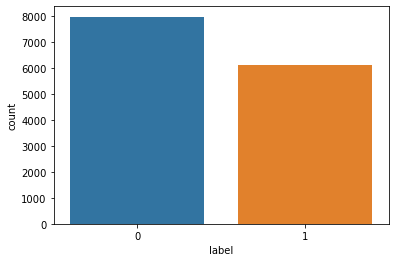

In [64]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

sdf = combined_df.select('label').toPandas()
sns.countplot(sdf['label'], label="Count");

# MODELING

In [66]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

splits = combined_df.randomSplit([0.70, 0.30])
train_df = splits[0]
test_df = splits[1]

gbm = GBTClassifier(maxIter=100, featuresCol="scaledFeatures", labelCol="label")
gbm_model = gbm.fit(train_df)
y_pred = gbm_model.transform(test_df)
y_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|      scaledFeatures|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(11,[0,1,4,7,8,10...|    0|[0.55448970672468...|[0.75193879360302...|       0.0|
|(11,[0,1,4,7,8,10...|    0|[-0.1713583159944...|[0.41514972597533...|       1.0|
|(11,[0,1,4,7,8,10...|    0|[0.46737462245592...|[0.71803781020603...|       0.0|
|(11,[0,1,4,7,8,10...|    0|[0.79267579644353...|[0.82996109930399...|       0.0|
|(11,[0,1,4,7,8,10...|    0|[1.02185283734484...|[0.88531006548138...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [67]:
accuracy = y_pred.select("label", "prediction")
accuracy.show(3)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
+-----+----------+
only showing top 3 rows



In [68]:
accuracy.filter(accuracy.label == accuracy.prediction).count() / accuracy.count()

0.7892037127503664

In [69]:
evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())


cv = CrossValidator(estimator=gbm,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

cv_model = cv.fit(train_df)
y_pred = cv_model.transform(test_df)
accuracy = y_pred.select("label", "prediction")
accuracy.filter(accuracy.label == accuracy.prediction).count() / accuracy.count()

0.7889594528578407

In [70]:
sc.stop()